<a href="https://colab.research.google.com/github/OdysseusPolymetis/philo_num_grenoble_24/blob/main/why_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Le TAL pour les langues anciennes : pourquoi faire ?**



Vous pouvez bien sûr utiliser de nombreux modules selon vos objets, sur lesquels nous reviendrons. Mais ce notebook a pour but de vous montrer aussi concrètement que possible pourquoi un pré-traitement des textes est souvent nécessaire.

In [ ]:
!git clone https://github.com/PerseusDL/treebank_data.git

In [3]:
import os
import xml.etree.ElementTree as ET
import string
import gdown

In [4]:
file_id = "1MZ4ld8j30ye3YGYy-T7V3Cyy1c4dlGks"
output_file = "stopwords_gk.txt"
#gdown.download(f"https://drive.google.com/uc?id={file_id}", output_file)
stopwords = open("/content/stopwords_gk.txt",'r',encoding="utf8").read().split("\n")

In [5]:
greek_dir = '/content/treebank_data/v2.1/Greek/texts'
latin_dir = '/content/treebank_data/v2.1/Latin/texts'

In [6]:
def parse_treebank_file(file_path):

    tree = ET.parse(file_path)
    root = tree.getroot()

    indexed_gold_sentences = []
    file_id1 = os.path.basename(file_path)
    print(file_id1)
    print(len(root.findall('.//sentence')))

    for i, sentence in enumerate(root.findall('.//sentence')):
        words = []
        for word in sentence.findall('.//word'):
            words.append({
                'form': word.get('form'),
                'lemma': word.get('lemma'),
                'postag': word.get('postag'),
                'relation': word.get('relation'),
                'head': word.get('head')
            })
        indexed_gold_sentences.append( words)
    return indexed_gold_sentences

In [7]:
def process_gold_directory(directory, filter_text):
    all_sentences = []

    for root, dirs, files in os.walk(directory):
        for file in files:
            if filter_text in file:
                file_path = os.path.join(root, file)
                sentences = parse_treebank_file(file_path)

                for sentence in sentences:
                    all_sentences.append(sentence)

                print(f"Processed {file_path}")

    return all_sentences

In [8]:
treebank_sentences=process_gold_directory(greek_dir, 'tlg0012')

tlg0012.tlg001.perseus-grc1.tb.xml
8415
Processed /content/treebank_data/v2.1/Greek/texts/tlg0012.tlg001.perseus-grc1.tb.xml
tlg0012.tlg002.perseus-grc1.tb.xml
6723
Processed /content/treebank_data/v2.1/Greek/texts/tlg0012.tlg002.perseus-grc1.tb.xml


In [9]:
forms=[]
lemmas=[]
no_stop=[]

for sentence in treebank_sentences:
  for word in sentence:
    if word["form"] not in string.punctuation and word["lemma"] not in stopwords:
      if word["lemma"] is not None:
        lemmas.append(word["lemma"])
        no_stop.append(word["lemma"])
      forms.append(word["form"])
    elif word["form"] not in string.punctuation:
      if word["lemma"] is not None:
        lemmas.append(word["lemma"])
      forms.append(word["form"])

In [10]:
len(lemmas)

208205

In [11]:
len(forms)

211957

In [12]:
len(no_stop)

104548

##Le TAL, qu'est-ce, et pourquoi ?
En termes généraux, beaucoup de gens ont recours au TAL pour la phase de prétraitement. Et c'est un passage bien souvent nécessaire si vous voulez éviter le pbruit dans les données, notamment sur le plan fréquentiel.
<br>Ici nous allons voir un exemple d'analyse fréquentielle avec et sans prétraitement.

Imaginons que nous voulions créer un nuage de mots pour représenter un texte particulier.
<br>Ici nous allons nous concentrer sur l'_Iliade_ et l'_Odyssée_ en même temps, en les prenant dans le treebank data de Perseus.

In [13]:
import unicodedata
def remove_accents_from_list(words_list):

    def remove_accents(input_str):
        nfkd_form = unicodedata.normalize('NFKD', input_str)
        return "".join([c for c in nfkd_form if not unicodedata.combining(c)])

    return [remove_accents(word) for word in words_list]

In [14]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np

def create_word_cloud(words_list, title):
    text = ' '.join(words_list)

    radius = 495
    diameter = radius * 2
    center = radius
    x, y = np.ogrid[:diameter, :diameter]
    mask = (x - center) ** 2 + (y - center) ** 2 > radius ** 2
    mask = 255 * mask.astype(int)

    mask_rgba = np.dstack((mask, mask, mask, 255 - mask))

    wordcloud = WordCloud(repeat=False, width=diameter, height=diameter,
                          background_color=None, mode="RGBA", colormap='plasma',
                          mask=mask_rgba).generate(text)

    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

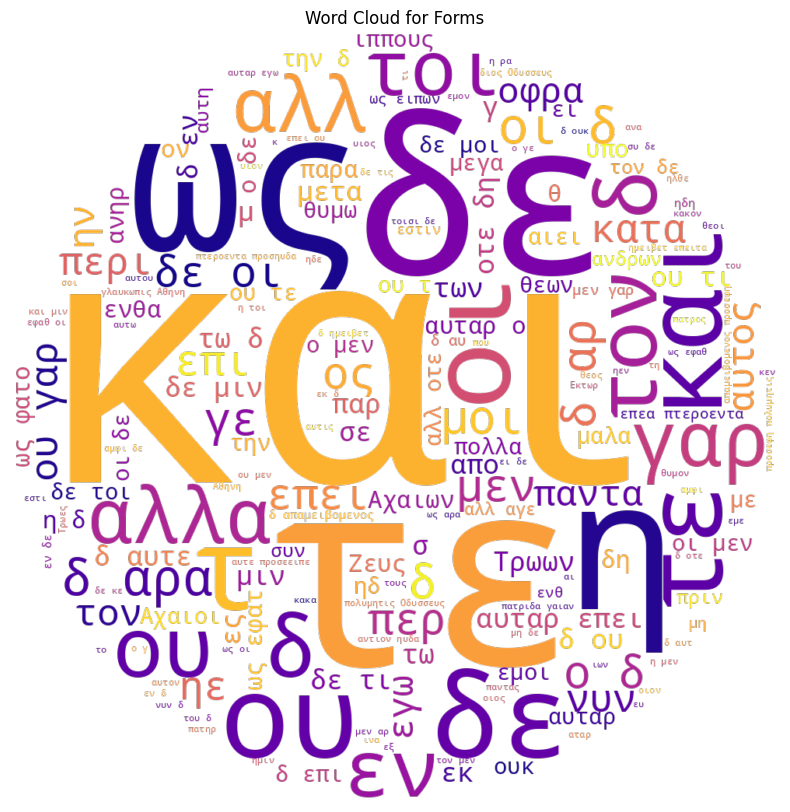

In [15]:
create_word_cloud(remove_accents_from_list(forms), 'Word Cloud for Forms')

Ce nuage ne sert pas à grand chose. Pourquoi ? Parce qu'il nous permet simplement de dire que le grec contient bon nombre de mots outils. Et sauf dans le cas d'une analyse stylistique, pour une représentation graphique, cela n'a guère de poids. Par ailleurs, bon nombre de mots sont encore sous leur forme flexionnelle : on a donc autant d'occurrences que de mots conjugués par exemple.
<br>Donc, **lemmatisons**.

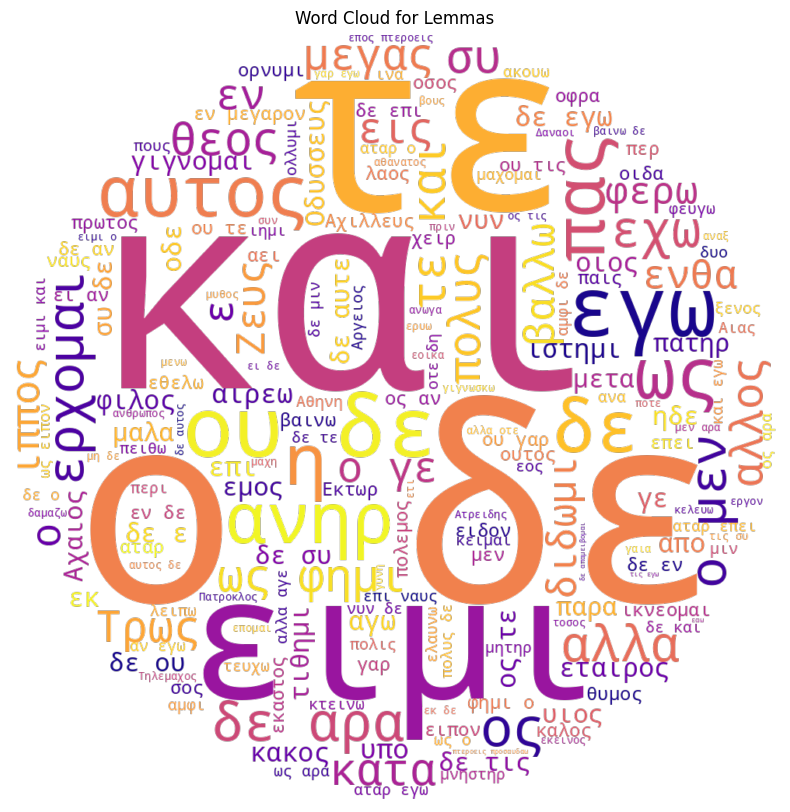

In [16]:
create_word_cloud(remove_accents_from_list(lemmas), 'Word Cloud for Lemmas')

Ça n'est pas beaucoup mieux, mais c'est mieux. Certains termes commencent à émerger.
<br>Cette fois, enlevons les **mots-outils**, et la ponctuation.

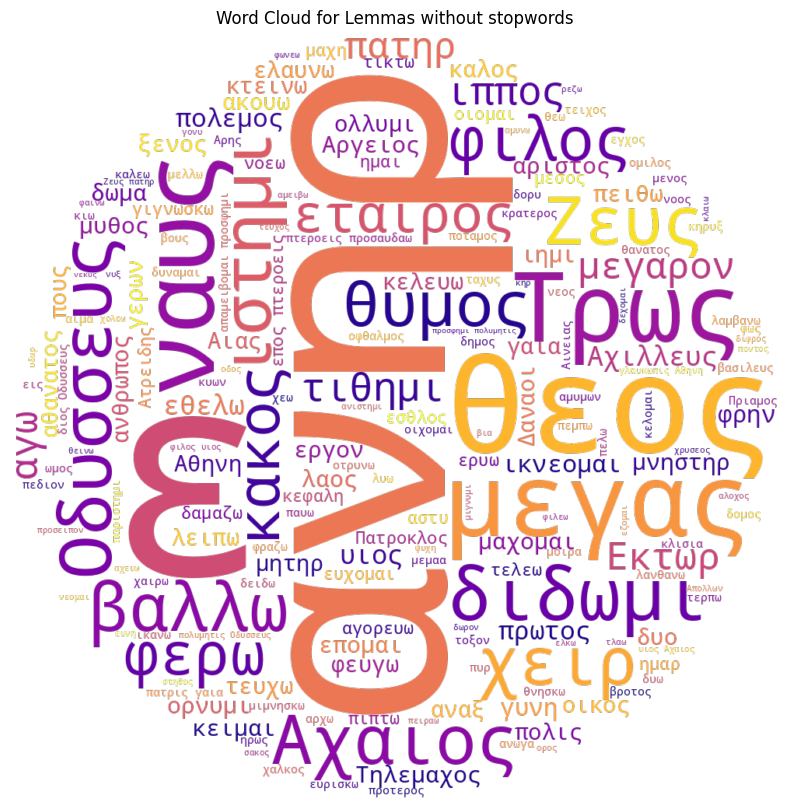

In [17]:
create_word_cloud(remove_accents_from_list(no_stop), 'Word Cloud for Lemmas without stopwords')

Clairement il s'agit d'un nuage beaucoup plus satisfaisant désormais.

## Expérience similaire sur les postags

Maintenant faisons quelque chose d'un peu similaire pour voir les postags.

In [18]:
postags=[]
no_stop_postags=[]

for sentence in treebank_sentences:
  for word in sentence:
    if word["form"] not in string.punctuation and word["lemma"] not in stopwords:
      if word["postag"] is not None:
        postags.append(word["postag"][0])
        no_stop_postags.append(word["postag"][0])
    elif word["form"] not in string.punctuation:
      if word["postag"] is not None:
        postags.append(word["postag"][0])

In [19]:
def create_word_cloud_postags(words_list, title):
    text = ' '.join(words_list)
    diameter = 1000
    radius = diameter // 2
    center = radius
    x, y = np.ogrid[:diameter, :diameter]
    mask = (x - center) ** 2 + (y - center) ** 2 > radius ** 2
    mask = 255 * mask.astype(int)
    mask_rgba = np.dstack((mask, mask, mask, 255 - mask))
    wordcloud = WordCloud(
        width=diameter,
        height=diameter,
        background_color=None,  # pour un fond transparent
        mode="RGBA",
        colormap='plasma',
        mask=mask_rgba,
        collocations=False,
        repeat=False,
        scale=2,
        min_font_size=10,
        max_words=200
    ).generate(text)

    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

In [20]:
print(postags[0:10])

['n', 'v', 'n', 'n', 'n', 'a', 'p', 'a', 'a', 'n']


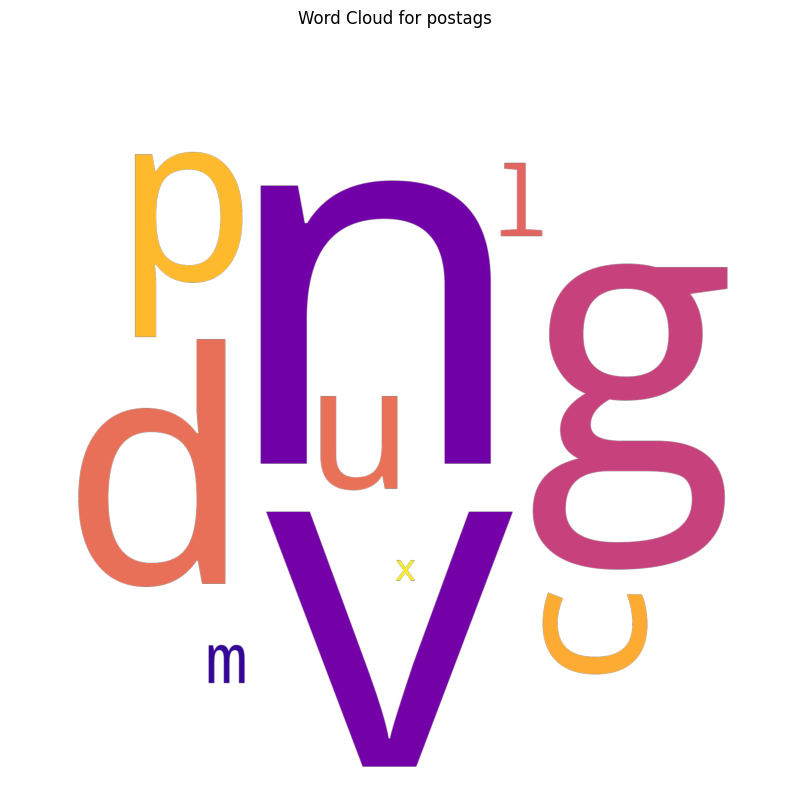

In [21]:
create_word_cloud_postags(postags, 'Word Cloud for postags')

Le constat est un peu le même qu'avant : on a du mal à déterminer quels sont les éléments les plus importants syntaxiquement. Essayons encore sans mots outils.

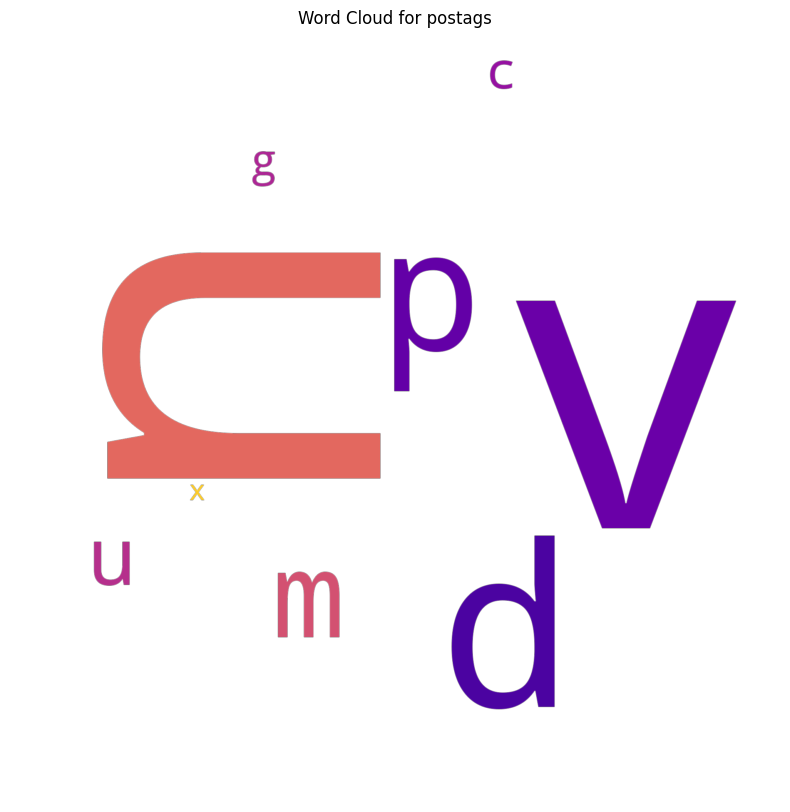

In [22]:
create_word_cloud_postags(no_stop_postags, 'Word Cloud for postags')

La dominante, pour discutable qu'elle soit, est déjà plus claire.

##Comment fait-on ?

##**Quelques outils utiles en ligne**

###**UDPipe**
Vous le trouverez [ici](https://lindat.mff.cuni.cz/services/udpipe/).
<br>Cet outil ne demande pas de savoir programmer, il est globalement très pratique.

###**Deucalion**
Vous le trouverez [ici](https://dh.chartes.psl.eu/deucalion/api/fr/).
<br>Particulièrement utile pour le français, l'ancien français et le latin.

###**VoyantTools**
Vous le trouverez [ici](https://voyant-tools.org/).
<br>Il ne s'agit pas tout à fait d'un outil de TAL, mais d'un outil de visualisation, qui mine de rien peut être assez poussé, surtout si vous le combinez avec les outils précédents.

#**TOKÉNISER, LEMMATISER, POSTAGGER**

Maintenant essayons **`stanza`**.
<br>Nous allons l'utiliser sur un texte un peu court, la première et la deuxième _Catilinaire_ de Cicéron.

Vous trouverez le lien vers le texte dans le [github](https://github.com/OdysseusPolymetis/philo_num_grenoble_24/blob/main/catilinaires.txt).

In [ ]:
!pip install stanza

In [24]:
filepath_of_text = "/content/catilinaires.txt"

In [25]:
full_text = open(filepath_of_text, encoding="utf-8").read()

##**stanza**

J'utilise généralement `stanza` pour trois raisons :
<br>- il y a un très grand nombre de langues traitées (Vous pouvez les consulter [ici](https://stanfordnlp.github.io/stanza/performance.html)),
<br>- c'est très rapide et ça fait un excellent usage de la GPU,
<br>- c'est facile à implémenter.

Pour télécharger des modèles spécifiques dans `stanza`, vous devrez rentrer les codes lettres des langues, que vous trouverez [ici](https://stanfordnlp.github.io/stanza/performance.html).
<br>Commençons avec le modèle latin par défaut.

In [ ]:
import stanza
stanza.download('la')

Beaucoup de modèles ont beaucoup de processus embarqués, et sont trop lourds. Je vous recommande d'être plus sélectifs lors de l'instanciation des processus. Vous pouvez le faire de cette manière :

In [ ]:
nlp_stanza = stanza.Pipeline(lang='la', processors='tokenize,pos,lemma')

Maintenant nous pouvons lancer l'analyse du `full_text`.

In [28]:
catilinaires_stanza=nlp_stanza(full_text)

Voyons un peu les résultats mot à mot.

In [ ]:
for sent in catilinaires_stanza.sentences:
  for token in sent.words:
    print(token.text + ' - ' + token.lemma + ' - ' + token.pos)

Globalement à l'oeil nu cela semble plutôt bon.

# **NER : NAMED ENTITY RECOGNITION**

Les **entités nommées** sont des éléments culturellement identifiables. Ils ne sont pas forcément un mot unique. Par exemple, "Rome" est une entité nommée, mais un outil NER pourrait aussi l'associer à l'expression "la ville aux sept collines".

Cette fois nous allons utiliser un moteur spacy pour voir les NER.



In [ ]:
!pip install spacy
!pip install https://huggingface.co/latincy/la_core_web_lg/resolve/main/la_core_web_lg-any-py3-none-any.whl

In [31]:
import spacy
nlp = spacy.load("la_core_web_lg")

In [ ]:
doc = nlp(full_text)

for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

Globalement je trouve les résultats plutôt bons.

Maintenant, tentons quelques visualisations de base, avec un outil très pratique, `nltk`.

In [33]:
import nltk

In [34]:
lemmas_catilinaires=[]
for sent in catilinaires_stanza.sentences:
  for token in sent.words:
    lemmas_catilinaires.append(token.lemma)
forms_catilinaires=[]
for sent in catilinaires_stanza.sentences:
  for token in sent.words:
    forms_catilinaires.append(token.text)

Vérifions ce qui se trouve dans les deux listes.

In [70]:
print(lemmas_catilinaires[0:20])
print(forms_catilinaires[0:20])

['qui', 'usque', 'tandem', 'abutor', ',', 'Catilina', ',', 'patientia', 'noster', '?', 'qui', 'diu', 'etiam', 'furor', 'iste', 'tuus', 'nos', 'eludeo', '?', 'qui']
['Quo', 'usque', 'tandem', 'abutere', ',', 'Catilina', ',', 'patientia', 'nostra', '?', 'quam', 'diu', 'etiam', 'furor', 'iste', 'tuus', 'nos', 'eludet', '?', 'quem']


Et voici quelques outils de base de `nltk` (mais il y en a beaucoup d'autres).

Là encore vous trouverez le fichier de stopwords dans le [github](https://github.com/OdysseusPolymetis/philo_num_grenoble_24/blob/main/stopwords_lat.txt).

In [35]:
stopset = open("/content/stopwords_lat.txt", encoding="utf-8").read().split("\n")

In [36]:
for lemma in lemmas_catilinaires:
    if not isinstance(lemma, str):
        print(f"Type non string trouvé : {lemma} (type : {type(lemma)})")

In [37]:
nltk_lemmas = nltk.Text(lemmas_catilinaires)

In [38]:
nltk_lemmas.concordance("Catilina")

Displaying 18 of 18 matches:
qui usque tandem abutor , Catilina , patientia noster ? qui diu etiam
ror atque tela uito . Ad mors tu , Catilina , duco ius consulus iam pridem opo
ceo . Habemus seno consulo in tu , Catilina , uehemens et grauis , non desum r
ulo confiscor tu interfectus sum , Catilina , conuenit. Viuis , et uiuis non a
 res publicus molior . Si tu iam , Catilina , comprehendo , si interfico iusse
efacio in senatus hesternus dies ; Catilina ipse pertimeo , profugio ; hic qui
is sum , qui Catilinae similis cum Catilina sentio non puto . Non sum iam leni
ntina urbs eiicio ! Uno meherculis Catilina exhauso leuo ego et recreo res pub
 perdo inuenio possum , qui se cum Catilina non familiaris uiuo fateor ? qui c
pater conscrribo detuluo . qui cum Catilina uenio , quis is senator appello , 
iuis in exilium eicio , quaesum ab Catilina , in nocturnus conuentus apud M- L
conseruo res publicus a Nunc si L. Catilina consilium , labor , periculum meus
abula nouus ? Errant , qui iste 

In [74]:
nltk_forms = nltk.Text(forms_catilinaires)

In [75]:
nltk_forms.concordance("Catilina")

Displaying 18 of 18 matches:
Quo usque tandem abutere , Catilina , patientia nostra ? quam diu etia
m ac tela uitemus . Ad mortem te , Catilina , duci iussu consulis iam pridem o
 Habemus senatus consultum in te , Catilina , uehemens et graue , non deest re
to confestim te interfectum esse , Catilina , conuenit. Viuis , et uiuis non a
i publicae molientem . Si te iam , Catilina , comprehendi , si interfici iusse
 patefeci in senatu hesterno die ; Catilina ipse pertimuit , profugit ; hi qui
is est , qui Catilinae similis cum Catilina sentire non putet . Non est iam le
nam urbis eiecerit ! Uno mehercule Catilina exhausto leuata mihi et recreata r
ditus inueniri potest , qui se cum Catilina non familiarissime uixisse fateatu
atres conscriptos detuli . Quo cum Catilina uenisset , quis eum senator appell
iuis in exilium eicio , quaesiui a Catilina , in nocturno conuentu apud M- Lae
eruandae rei publicae ! Nunc si L. Catilina consiliis , laboribus , periculis 
bulas nouas ? Errant , qui ista

Un outil que j'utilise souvent, pour voir les expressions fréquentes significatives : `BigramCollocationFinder`.

In [39]:
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures

In [40]:
bcf = BigramCollocationFinder.from_words(lemmas_catilinaires)
filter_stops = lambda w: len(w) < 3 or w in stopset
bcf.apply_word_filter(filter_stops)
bcf.nbest(BigramAssocMeasures.likelihood_ratio, 30)

[('aer', 'alienus'),
 ('seno', 'consulo'),
 ('fortis', 'uir'),
 ('tabula', 'nouus'),
 ('terra', 'marique'),
 ('totus', 'Italiae'),
 ('populus', 'Romano'),
 ('aes', 'alienus'),
 ('exilium', 'eicio'),
 ('magnus', 'opus'),
 ('pridem', 'oportet'),
 ('castra', 'confero'),
 ('Ahala', 'Sp.'),
 ('Apulia', 'adtribuo'),
 ('Fuluius', 'consularis'),
 ('Gallicanis', 'legio'),
 ('Gracchum', 'mediocriter'),
 ('Iouis', 'Statoris'),
 ('Saturninum', 'tribunus'),
 ('Seruilius', 'Ahala'),
 ('Sp.', 'Maelium'),
 ('Uno', 'meherculis'),
 ('aedes', 'Iouis'),
 ('aleus', 'comissatio'),
 ('antelucanis', 'cenis'),
 ('antiquus', 'praetereo'),
 ('apparo', 'delecto'),
 ('asuefacio', 'frigus'),
 ('audacius', 'consumo'),
 ('bene', 'barbatum')]

In [41]:
bcf = BigramCollocationFinder.from_words(forms_catilinaires)
filter_stops = lambda w: len(w) < 3 or w in stopset
bcf.apply_word_filter(filter_stops)
bcf.nbest(BigramAssocMeasures.likelihood_ratio, 30)

[('aere', 'alieno'),
 ('aes', 'alienum'),
 ('terra', 'marique'),
 ('magno', 'opere'),
 ('populo', 'Romano'),
 ('totius', 'Italiae'),
 ('senatus', 'consulto'),
 ('senatus', 'consultum'),
 ('pridem', 'oportebat'),
 ('bellum', 'populo'),
 ('Ahala', 'Sp.'),
 ('Apulia', 'adtributa'),
 ('Aurelia', 'uia'),
 ('Fuluius', 'consularis'),
 ('Gallicanis', 'legionibus'),
 ('Gracchum', 'mediocriter'),
 ('Iouis', 'Statoris'),
 ('Maelium', 'nouis'),
 ('Mea', 'lenitas'),
 ('Picenumque', 'praemisi'),
 ('Saturninum', 'tribunum'),
 ('Seruilium', 'praetorem'),
 ('Seruilius', 'Ahala'),
 ('Sine', 'dubio'),
 ('Sp.', 'Maelium'),
 ('Statoris', 'conuocaui'),
 ('Valerio', 'consulibus'),
 ('acrioribus', 'suppliciis'),
 ('adducti', 'dissolui'),
 ('adiuuando', 'pollicebatur')]

Et enfin un outil de visualisation, `matplotlib`.

In [77]:
import matplotlib.pyplot as plt

In [42]:
from collections import Counter
filtered_lemmas = [word for word in lemmas_catilinaires if word not in stopset and word not in string.punctuation]
word_counts = Counter(filtered_lemmas)
most_common_words = word_counts.most_common(20)
most_common_words

[('publicus', 24),
 ('urbs', 22),
 ('uolo', 19),
 ('homo', 19),
 ('Catilina', 18),
 ('modus', 18),
 ('Quirites', 16),
 ('uerus', 15),
 ('bellum', 15),
 ('magnus', 13),
 ('scelus', 12),
 ('consulus', 11),
 ('genus', 10),
 ('consilium', 9),
 ('sentio', 9),
 ('Catilinam', 9),
 ('ciuis', 9),
 ('puto', 9),
 ('exilium', 9),
 ('bonus', 8)]

Voilà par exemple un 'scatter plot' sur certains termes qui apparaissent dans les _Catilinaires_.

In [43]:
def plot_word_dispersion(text, words):
    word_positions = {word: [] for word in words}

    for index, word in enumerate(text):
        if word in word_positions:
            word_positions[word].append(index)

    plt.figure(figsize=(10, 6))
    colors = ['r', 'g', 'b', 'y', 'c', 'm', 'k']
    for i, (word, positions) in enumerate(word_positions.items()):
        plt.plot(positions, [i] * len(positions), 'o', label=word, color=colors[i % len(colors)])

    plt.yticks(range(len(words)), words)
    plt.ylim(-1, len(words))
    plt.title("Graphique de Dispersion des Mots")
    plt.xlabel("Position dans le texte")
    plt.ylabel("Mots")

    plt.legend()
    plt.show()

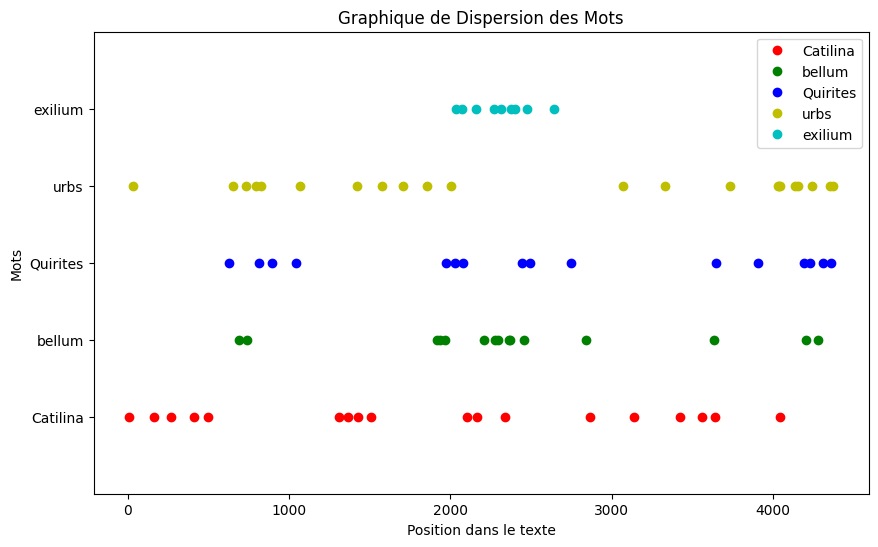

In [44]:
plot_word_dispersion(text=lemmas_catilinaires, words=['Catilina', 'bellum', 'Quirites', 'urbs', 'exilium'])

Et une reprise de la fonction tirée de `wordcloud` de tout à l'heure.

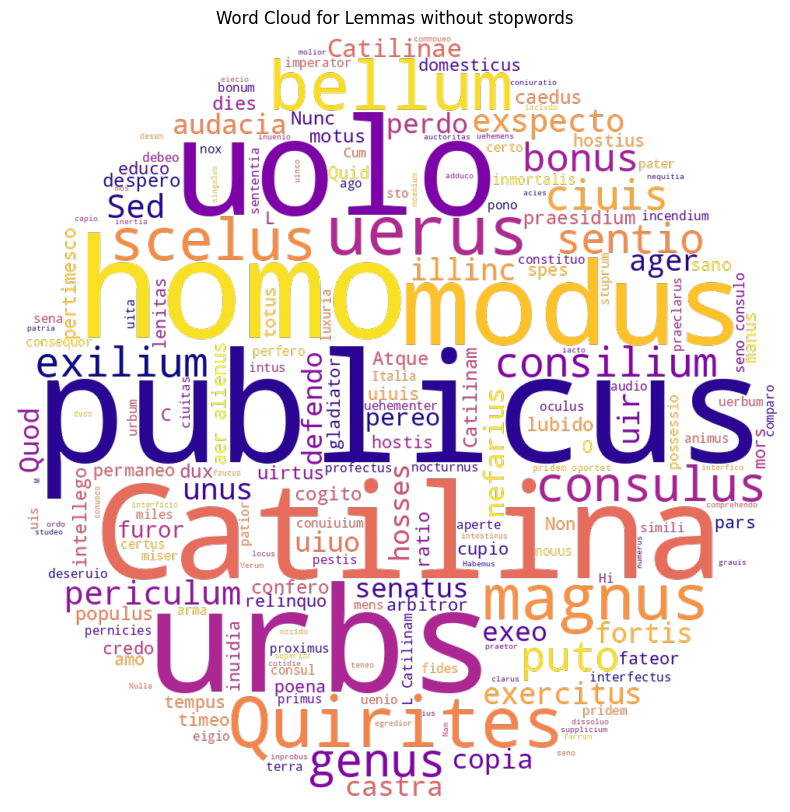

In [117]:
create_word_cloud(filtered_lemmas, 'Word Cloud for Lemmas without stopwords')